In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, ReLU, Bidirectional,BatchNormalization, Embedding, Conv1D, MaxPool1D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] =False
plt.rcParams.update({"font.size":20})
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, recall_score

In [2]:
negative = pd.read_csv('data/Negative.txt', header = None, index_col=None) 
negative = negative.drop_duplicates()
negative['label'] = 0
positive = pd.read_csv('data/Positive.txt', header = None, index_col=None) 
positive = positive.drop_duplicates()
positive['label'] = 1
# negative[negative.isnull().values==True] # 判断是否存在缺失值

In [3]:
data = pd.concat([negative, positive], axis=0).reset_index().iloc[:, 1:]
data = data.dropna()

In [4]:
x_data = data.iloc[:, :-1]
y_data = data.loc[:, 'label']
# 类别均衡化
model_smote = SMOTE()  
x_resampled, y_resampled = model_smote.fit_resample(x_data,y_data)

In [5]:
# 划分训练数据为80%训练集和20%的验证集
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=7, shuffle=True)

In [64]:
# # 重置数据维度
# print(x_train.shape)
# x_train = x_train.reshape(-1,1,x_train.shape[-1])
# x_test = x_test.reshape(-1,1,x_test.shape[-1])
# print(x_train.shape)

(1777, 2000)
(1777, 1, 2000)


In [6]:
# 对类别数据进行onehot编码
print(y_train.shape)
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
print(y_train.shape)

(1777,)
(1777, 2)


In [7]:
# 构建网络
model = Sequential()
model.add(Embedding(input_dim=21, input_length=2000, output_dim=128))
model.add(Conv1D(128,16, activation='relu'))
model.add(Conv1D(64,16, activation='relu'))
model.add(MaxPool1D(pool_size=5,strides=5))

model.add(Bidirectional(LSTM(units=64, return_sequences=True, activation='relu')))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(units=64)))
model.add(BatchNormalization())
model.add(Dense(2, activation = 'softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 128)         2688      
_________________________________________________________________
conv1d (Conv1D)              (None, 1985, 128)         262272    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1970, 64)          131136    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 394, 64)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 394, 128)          66048     
_________________________________________________________________
batch_normalization (BatchNo (None, 394, 128)          512       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               9

In [8]:
# 训练网络
epochs = 100 # 训练周期
batch_size = 64 # 批次大小 
# 监视网络的训练，并将在验证集上取得最优结果的网络权重保留下来
checkpoint = ModelCheckpoint("BiLSTM_V5_2.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max') 
# 监视网络的训练，并对学习率进行衰减处理
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=20, verbose=1)
callbacks_list = [checkpoint, reduce_lr] # 监视列表 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # 编译网络
# 开始训练，直接使用30%的验证集，在训练过程中测试网络
history = model.fit(x_train, y_train, callbacks=callbacks_list, epochs=epochs, batch_size=batch_size, verbose=1,validation_data=(x_test, y_test))

Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: 0.4096 - accuracy: 0.8137
Epoch 00001: val_accuracy improved from -inf to 0.53708, saving model to BiLSTM_V5_2.h5
28/28 [==============================] - 61s 2s/step - loss: 0.4096 - accuracy: 0.8137 - val_loss: 0.6830 - val_accuracy: 0.5371 - lr: 0.0010
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 0.2269 - accuracy: 0.9145
Epoch 00002: val_accuracy improved from 0.53708 to 0.65169, saving model to BiLSTM_V5_2.h5
28/28 [==============================] - 60s 2s/step - loss: 0.2269 - accuracy: 0.9145 - val_loss: 0.6704 - val_accuracy: 0.6517 - lr: 0.0010
Epoch 3/100
28/28 [==============================] - ETA: 0s - loss: 0.0820 - accuracy: 0.9736
Epoch 00003: val_accuracy improved from 0.65169 to 0.67416, saving model to BiLSTM_V5_2.h5
28/28 [==============================] - 61s 2s/step - loss: 0.0820 - accuracy: 0.9736 - val_loss: 0.6683 - val_accuracy: 0.6742 - lr: 0.0010
Epoch 4/100
28/28 [

Epoch 28/100
28/28 [==============================] - ETA: 0s - loss: 7.2163e-05 - accuracy: 1.0000
Epoch 00028: val_accuracy did not improve from 0.90112
28/28 [==============================] - 69s 2s/step - loss: 7.2163e-05 - accuracy: 1.0000 - val_loss: 0.3953 - val_accuracy: 0.8989 - lr: 0.0010
Epoch 29/100
28/28 [==============================] - ETA: 0s - loss: 1.0598e-04 - accuracy: 1.0000
Epoch 00029: val_accuracy did not improve from 0.90112
28/28 [==============================] - 64s 2s/step - loss: 1.0598e-04 - accuracy: 1.0000 - val_loss: 0.4381 - val_accuracy: 0.8966 - lr: 0.0010
Epoch 30/100
28/28 [==============================] - ETA: 0s - loss: 6.3180e-05 - accuracy: 1.0000
Epoch 00030: val_accuracy did not improve from 0.90112
28/28 [==============================] - 70s 3s/step - loss: 6.3180e-05 - accuracy: 1.0000 - val_loss: 0.4064 - val_accuracy: 0.8944 - lr: 0.0010
Epoch 31/100
28/28 [==============================] - ETA: 0s - loss: 1.3968e-04 - accuracy: 1.00

Epoch 55/100
28/28 [==============================] - ETA: 0s - loss: 2.3862e-05 - accuracy: 1.0000
Epoch 00055: val_accuracy did not improve from 0.90337
28/28 [==============================] - 66s 2s/step - loss: 2.3862e-05 - accuracy: 1.0000 - val_loss: 0.4801 - val_accuracy: 0.8989 - lr: 5.0000e-04
Epoch 56/100
28/28 [==============================] - ETA: 0s - loss: 2.7884e-05 - accuracy: 1.0000
Epoch 00056: val_accuracy did not improve from 0.90337
28/28 [==============================] - 66s 2s/step - loss: 2.7884e-05 - accuracy: 1.0000 - val_loss: 0.4565 - val_accuracy: 0.9011 - lr: 5.0000e-04
Epoch 57/100
28/28 [==============================] - ETA: 0s - loss: 4.1196e-05 - accuracy: 1.0000
Epoch 00057: val_accuracy did not improve from 0.90337
28/28 [==============================] - 62s 2s/step - loss: 4.1196e-05 - accuracy: 1.0000 - val_loss: 0.4558 - val_accuracy: 0.9034 - lr: 5.0000e-04
Epoch 58/100
28/28 [==============================] - ETA: 0s - loss: 3.0838e-05 - ac

Epoch 82/100
28/28 [==============================] - ETA: 0s - loss: 2.7947e-05 - accuracy: 1.0000
Epoch 00082: val_accuracy did not improve from 0.90562
28/28 [==============================] - 61s 2s/step - loss: 2.7947e-05 - accuracy: 1.0000 - val_loss: 0.4522 - val_accuracy: 0.8944 - lr: 5.0000e-04
Epoch 83/100
28/28 [==============================] - ETA: 0s - loss: 2.1541e-05 - accuracy: 1.0000
Epoch 00083: val_accuracy did not improve from 0.90562
28/28 [==============================] - 67s 2s/step - loss: 2.1541e-05 - accuracy: 1.0000 - val_loss: 0.4528 - val_accuracy: 0.8944 - lr: 5.0000e-04
Epoch 84/100
28/28 [==============================] - ETA: 0s - loss: 2.0950e-05 - accuracy: 1.0000
Epoch 00084: val_accuracy did not improve from 0.90562
28/28 [==============================] - 66s 2s/step - loss: 2.0950e-05 - accuracy: 1.0000 - val_loss: 0.4518 - val_accuracy: 0.8966 - lr: 5.0000e-04
Epoch 85/100
28/28 [==============================] - ETA: 0s - loss: 2.2249e-05 - ac

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


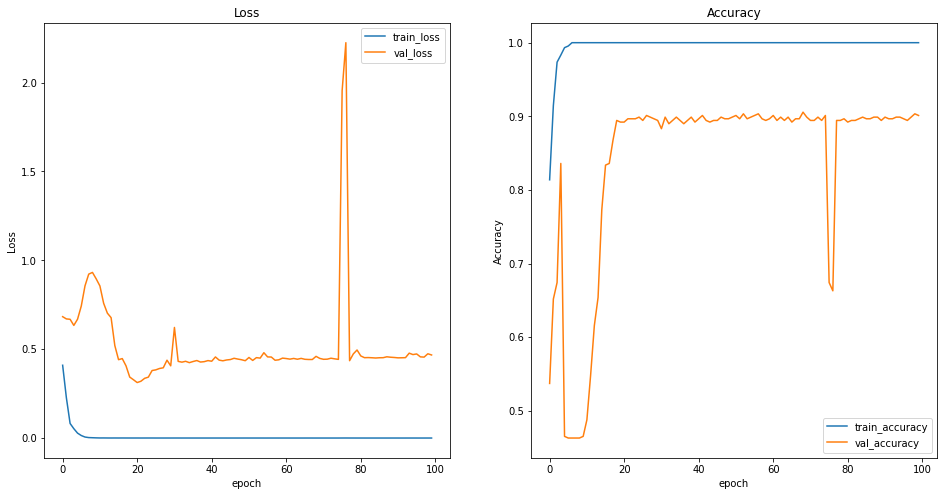

In [9]:
# 可视化训练过程中，训练集与验证集的损失和精度
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.plot(history.history['loss'],label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'],label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [10]:
# 使用模型得到预测结果
model = load_model('BiLSTM_V5_2.h5')
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

In [11]:
print('在80%训练集上, accuracy: {:.4}% 召回率: {:4}, f1: {:4}'.format(accuracy_score(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1)), recall_score(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1), average='binary'), f1_score(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1), average='binary')))
print('在20%测试集上, accuracy: {:.4}% 召回率: {:4}, f1: {:4}'.format(accuracy_score(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1)), recall_score(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1), average='binary'), f1_score(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1), average='binary')))

在80%训练集上, accuracy: 1.0% 召回率:  1.0, f1:  1.0
在20%测试集上, accuracy: 0.9056% 召回率: 0.8828451882845189, f1: 0.9094827586206897


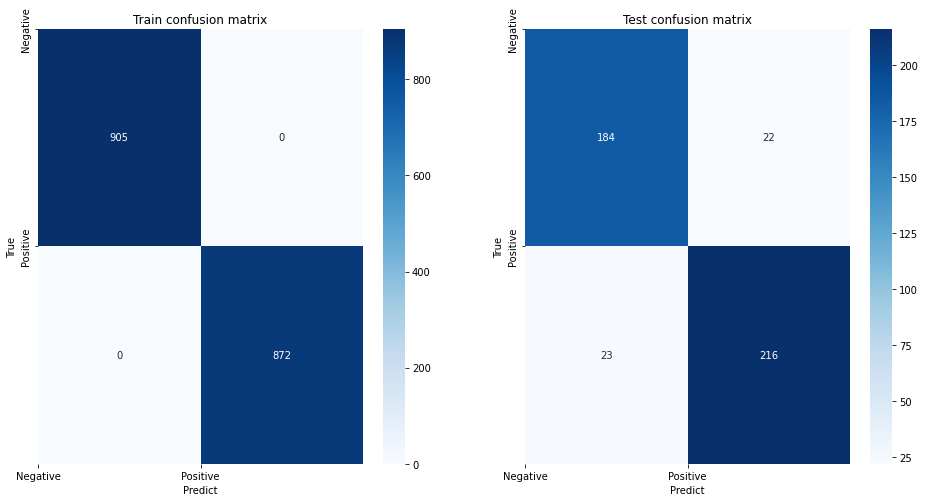

In [17]:
# 绘制混淆矩阵
plt.figure(figsize=(16,8))
plt.subplot(121)
matrix = confusion_matrix(np.argmax(y_train, axis = 1), np.argmax(y_train_pred, axis = 1))
sns.heatmap(matrix,annot=True,cmap="Blues",fmt='g') 
plt.title('Train confusion matrix') 
plt.xticks(range(2), ['Negative', 'Positive'])
plt.yticks(range(2), ['Negative', 'Positive'])
plt.xlabel('Predict') 
plt.ylabel('True')
plt.subplot(122)
matrix = confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(y_test_pred, axis = 1))
sns.heatmap(matrix,annot=True,cmap="Blues",fmt='g') 
plt.title('Test confusion matrix') 
plt.xticks(range(2), ['Negative', 'Positive'])
plt.yticks(range(2), ['Negative', 'Positive'])
plt.xlabel('Predict') 
plt.ylabel('True')
plt.show()